In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import cv2  
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [9]:
# Define parameters
img_width, img_height = 224, 224
batch_size = 32

In [10]:
def load_images_and_labels(directory, img_size=(224, 224)):
    images = []
    labels = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if os.path.isfile(file_path):
                    try:
                        img = cv2.imread(file_path)
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(subdir)  
                    except Exception as e:
                        print(f"Error loading image: {file_path}, Error: {e}")
    return np.array(images), np.array(labels)

In [11]:
import os
import shutil
import cv2

# Define paths to the train, test, and val directories
train_path = '../Cotton Disease/train'
test_path = '../Cotton Disease/test'
val_path = '../Cotton Disease/val'
combined_path = '../Cotton Disease/combined'

# Create the combined directory if it doesn't exist
os.makedirs(combined_path, exist_ok=True)

# Function to check if a file is a valid image
def is_valid_image(file_path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions)

# Function to copy images from source directory to destination directory  
def copy_images(source_dir, dest_dir):
    for subdir in os.listdir(source_dir):
        subdir_path = os.path.join(source_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)

                # Skip hidden files like .DS_Store ...........
                if file.startswith('.'):
                    continue

                # Check if the file is a valid image
                if is_valid_image(file_path):
                    dest_subdir_path = os.path.join(dest_dir, subdir)
                    os.makedirs(dest_subdir_path, exist_ok=True)
                    try:
                        shutil.copy(file_path, os.path.join(dest_subdir_path, file))
                        print(f"Successfully copied: {file_path}")
                    except Exception as e:
                        print(f"Error copying file: {file_path}, Error: {e}")
                else:
                    print(f"Skipping non-image file: {file_path}")

# Copy images from train directory
copy_images(train_path, combined_path)

# Copy images from test directory
copy_images(test_path, combined_path)

# Copy images from val directory
copy_images(val_path, combined_path)

print("Images combined successfully.")

Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (536)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (470)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (193)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (646)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (120)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (911)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (316)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (857)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (585)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (250)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/dd (7)_iaip.jpg
Successfully copied: ../Cotton Disease/train/diseased cotton plant/

In [12]:
# Function to count images in a directory (and subdirectories if applicable)
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.endswith(('.png', '.jpg', '.jpeg'))])
    return count

# Count images in each dataset
train_size = count_images(train_path)
test_size = count_images(test_path)
val_size = count_images(val_path)

# Print the sizes
print(f"Train Dataset Size: {train_size} images")
print(f"Test Dataset Size: {test_size} images")
print(f"Validation Dataset Size: {val_size} images")

Train Dataset Size: 1951 images
Test Dataset Size: 106 images
Validation Dataset Size: 253 images


In [13]:
import os
import cv2
import numpy as np

def load_images_and_labels(directory, img_size=(224, 224)):
    images = []
    labels = []
    allowed_extensions = {'.jpg', '.jpeg', '.png'}  # Add extensions as needed

    for root, _, files in os.walk(directory):
        for file in files:
            # Check if file extension is in allowed_extensions
            if os.path.splitext(file)[-1].lower() in allowed_extensions:
                file_path = os.path.join(root, file)
                try:
                    # Load and resize image
                    img = cv2.imread(file_path)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    
                    # Extract label from directory structure
                    label = os.path.basename(root)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image: {file_path}, Error: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)
    
    return images, labels

In [14]:
combined_path = '../Cotton Disease'
X, y = load_images_and_labels(combined_path, img_size=(img_width, img_height))

In [15]:
# Encode labels using one-hot encoding
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [17]:
# Normalize pixel values (0 to 255) to (0 to 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
# Load VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional base
base_model.trainable = False

In [19]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(lb.classes_), activation='softmax'))

In [20]:
# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Train the model using preprocessed data without augmentation
history = model.fit(
    X_train, y_train,
    epochs=9,  
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

Epoch 1/9
101/101 [==============================] - 686s 7s/step - loss: 0.4415 - accuracy: 0.8398 - val_loss: 0.7369 - val_accuracy: 0.8380
Epoch 2/9
101/101 [==============================] - 843s 8s/step - loss: 0.3580 - accuracy: 0.8661 - val_loss: 0.5075 - val_accuracy: 0.8742
Epoch 3/9
101/101 [==============================] - 747s 7s/step - loss: 0.3011 - accuracy: 0.8897 - val_loss: 0.3335 - val_accuracy: 0.8966
Epoch 4/9
101/101 [==============================] - 756s 8s/step - loss: 0.2786 - accuracy: 0.8925 - val_loss: 0.2286 - val_accuracy: 0.9270
Epoch 5/9
101/101 [==============================] - 838s 8s/step - loss: 0.2556 - accuracy: 0.9039 - val_loss: 0.2031 - val_accuracy: 0.9255
Epoch 6/9
101/101 [==============================] - 858s 9s/step - loss: 0.2282 - accuracy: 0.9123 - val_loss: 0.1860 - val_accuracy: 0.9306
Epoch 7/9
101/101 [==============================] - 1083s 11s/step - loss: 0.1969 - accuracy: 0.9278 - val_loss: 0.1653 - val_accuracy: 0.9414
Epoc

In [41]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optional: Save the model
model.save('cotton_disease_vgg16.h5')
print("Model saved as 'cotton_disease_vgg16.h5'")

44/44 [==============================] - 196s 4s/step - loss: 0.1443 - accuracy: 0.9443
Test Accuracy: 94.43%
Model saved as 'cotton_disease_vgg16.h5'


In [42]:
import os

# Define paths
image_folders = [
    '/Users/shubhampund9767/Desktop/Yolo Project/Cotton Disease/train/diseased cotton leaf',
    '/Users/shubhampund9767/Desktop/Yolo Project/Cotton Disease/train/diseased cotton plant',
    '/Users/shubhampund9767/Desktop/Yolo Project/Cotton Disease/train/fresh cotton leaf',
    '/Users/shubhampund9767/Desktop/Yolo Project/Cotton Disease/train/fresh cotton plant'
]

# Define output folder for the labels
output_folder = '/Users/shubhampund9767/Desktop/Yolo Project/Cotton Disease/labels/'

# Define class names and assign a class ID (start from 0)
class_names = ['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']
class_ids = {name: index for index, name in enumerate(class_names)}

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to create label files
def create_label_file(image_path, class_id):
    image_name = os.path.splitext(os.path.basename(image_path))[0]  # Remove extension
    label_file_path = os.path.join(output_folder, f'{image_name}.txt')

    # Create the label file with class ID (and bounding boxes if available)
    with open(label_file_path, 'w') as f:
        # Assuming no bounding boxes for now, just the class ID
        f.write(f'{class_id} 0.5 0.5 1.0 1.0\n')  # Dummy bounding box (center, width, height)

# Process each folder and each image
for folder in image_folders:
    class_name = os.path.basename(folder)
    class_id = class_ids[class_name]  # Get class ID based on folder name
    
    # Loop through all images in the folder
    for image_name in os.listdir(folder):
        if image_name.endswith(('.jpg', '.png')):  # Ensure only image files are processed
            image_path = os.path.join(folder, image_name)
            create_label_file(image_path, class_id)

print(f"Label files have been created in {output_folder}")

Label files have been created in /Users/shubhampund9767/Desktop/Yolo Project/Cotton Disease/labels/


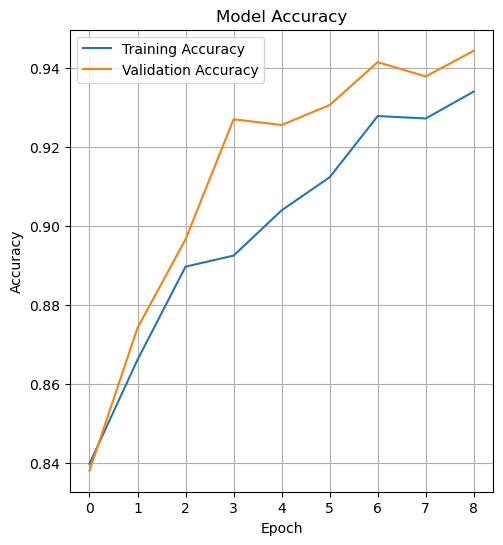

In [43]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()



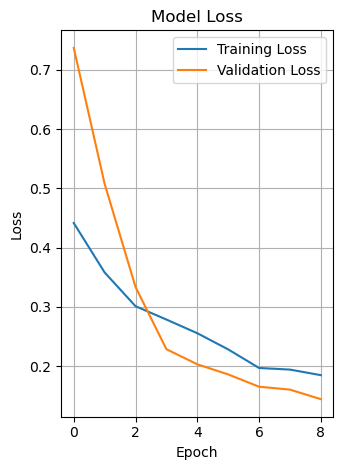

In [44]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

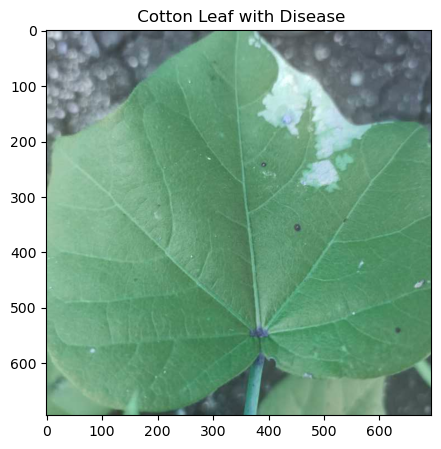

In [45]:
image = cv2.imread('../Cotton Disease/train/diseased cotton leaf/dis_leaf (101)_iaip.jpg')
image = cv2.imread('../Cotton Disease/train/diseased cotton leaf/dis_leaf (105)_iaip.jpg')
plt.figure(figsize=(5,5)) 
plt.title(' Cotton Leaf with Disease')
plt.imshow(image)

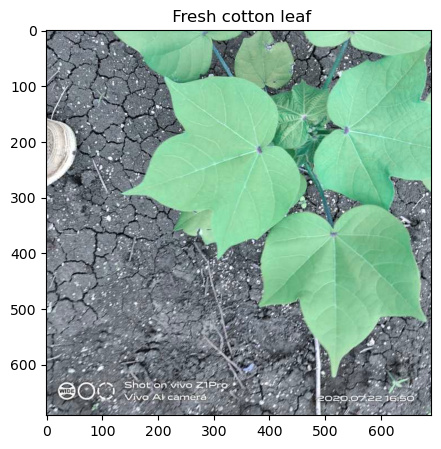

In [27]:
image = cv2.imread('../Cotton Disease/train/fresh cotton leaf/d (100)_iaip.jpg')

plt.figure(figsize=(5,5)) 
plt.title(' Fresh cotton leaf')
plt.imshow(image)

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def predict_image(image_path, class_names):
    """
    Predicts the class of an image using the trained model.

    Args:
        image_path (str): Path to the image to predict.
        class_names (list): List of class labels.

    Returns:
        str: Predicted class label.
        float: Confidence score of the prediction.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Replace with your model's input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    print(f"Raw predictions: {predictions}")  # Debugging output
    
    # Get the predicted class index and confidence
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index]
    
    # Check if predicted index is valid
    if predicted_index >= len(class_names):
        raise ValueError(
            f"Predicted index {predicted_index} exceeds the number of class labels in class_names {len(class_names)}."
        )
    
    # Map predicted index to class label
    predicted_class = class_names[predicted_index]
    
    return predicted_class, confidence

In [4]:
class_names = ['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']

# Example: Predict for a sample image
image_path = "./cotton.jpeg"
predicted_class, confidence = predict_image(image_path, class_names)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence Score: {confidence:.2f}")

NameError: name 'np' is not defined

In [52]:
pip install flask_cors

  Using cached Flask_Cors-5.0.0-py2.py3-none-any.whl.metadata (5.5 kB)
Using cached Flask_Cors-5.0.0-py2.py3-none-any.whl (14 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:

  # Import the Jupyter notebook as a module
from flask import Flask, request, jsonify
from flask_cors import CORS
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import base64

# Import predict_image from model


# Initialize Flask app
app = Flask(__name__)
CORS(app)

# Load YOLO and VGG16 models
yolo_model = YOLO('yolov5su.pt')  # Replace with the correct YOLO model path
vgg16_model = load_model('cotton_disease_vgg16.h5')  # Replace with your VGG16 model path

# Class names based on the dataset
classes = ['Diseased Cotton Leaf', 'Diseased Cotton Plant', 'Fresh Cotton Leaf', 'Fresh Cotton Plant']

# Confidence threshold for YOLO detection
CONFIDENCE_THRESHOLD = 0.7


def process_image(image):
    """
    Detect objects using YOLO and classify them using VGG16.
    
    Args:
    - image (numpy array): The input image.

    Returns:
    - detections (list): List of detections with labels, confidence, and bounding box.
    """
    # Run YOLO model on the image
    results = yolo_model(image)

    detections = []
    if results[0].boxes is not None:
        for detection in results[0].boxes:
            confidence = detection.conf[0]
            if confidence >= CONFIDENCE_THRESHOLD:
                # Extract bounding box coordinates
                x1, y1, x2, y2 = map(int, detection.xyxy[0])
                crop = image[y1:y2, x1:x2]

                # Resize and preprocess the crop for VGG16
                crop_resized = cv2.resize(crop, (224, 224))
                crop_preprocessed = preprocess_input(np.expand_dims(crop_resized, axis=0))

                # Predict using VGG16
                vgg16_prediction = vgg16_model.predict(crop_preprocessed)
                class_index = np.argmax(vgg16_prediction)
                confidence_score = np.max(vgg16_prediction)
                print(f"Detected class: {classes[class_index]}, Confidence: {confidence_score}")
                detections.append({
                    "label": classes[class_index],
                    "confidence": float(confidence_score),
                    "box": [x1, y1, x2, y2]
                })
    return detections


@app.route('/process', methods=['POST'])
def process():
    """
    Flask API endpoint to process uploaded images for detection and classification.

    Returns:
    - JSON response with detections and annotated image.
    """
    if 'file' not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    # Read the uploaded image
    file = request.files['file']
    file_bytes = np.frombuffer(file.read(), np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    # Process the image for detections using predict_image
    detections = predict_image(image)  # Call your function from model.ipynb

    # Draw bounding boxes and labels on the image
    for detection in detections:
        x1, y1, x2, y2 = detection['box']
        label = f"{detection['label']} ({detection['confidence']:.2f})"

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Put label text
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Encode the image with bounding boxes to base64
    _, buffer = cv2.imencode('.jpg', image)
    encoded_image = base64.b64encode(buffer).decode('utf-8')

    return jsonify({"detections": detections, "image": encoded_image})


if __name__ == "__main__":
    # Run Flask app
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 15, in <module>
    from ipykernel import kernelapp as app
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/__init__.py", line 7, in <module>
    from .connect import *
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/connect.py", line 12, in <module>
    import jupyter_client
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/__init__.py", line 3, in <module>
    from .asynchronous import AsyncKernelClient
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/asynchronous/__init__.py", line 1, in <module>
    from .client import AsyncKernelClient  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/asynchronous/client.py", line 11, in <module>
    from ..chann

SystemExit: 1

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
